In [4]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [5]:
import os

os.sys.path.append("../")

# Implementation of Fast Histo Version 2

In [9]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

hep.style.use("CMS")
from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [10]:
from statsmodels.stats.proportion import proportion_confint

/home/lucas/anaconda3/envs/db-clustering/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [12]:
import copy

In [13]:
import pickle

In [14]:
tqdm.pandas()

In [25]:
from matplotlib.colors import LogNorm

# Primary Vertex Class

In [24]:
class PrimaryVertexing(object):
    def __init__(self, object):
        self.fh_bins = object["fh_bins"]
        self.eta_bins = np.array([0.0, 0.7, 1.0, 1.2, 1.6, 2.0, 2.4])
        self.deltaz_bins = np.array([0.0, 0.4, 0.6, 0.76, 1.0, 1.7, 2.2, 0.0])
        self.test_run = object["test_run"]
        self.trk = object["track_data"]
        if self.test_run:
            self.trk = self.trk.query("entry<=10").copy()
        self.mc = object["truth_data"]
        print("Initialized Primary Vertexing setup")

    def z0_reco_fh(self, max_index: int) -> float:
        "Function returns the reconstructed z0 value for fast histo based on the maximum bin"
        bin_edges = self.fh_bins
        half_bin_width = 0.5 * (bin_edges[1] - bin_edges[0])
        lowest_bin = bin_edges[0]
        highest_bin = bin_edges[-1]
        nbins = bin_edges.shape[0]

        z0 = (
            lowest_bin
            + (highest_bin - lowest_bin) * (max_index / nbins)
            + half_bin_width
        )

        return z0

    def fh_pv_association(
        self, distance_from_pv: np.array, eta: np.array
    ) -> np.array(np.float32):

        eta_bin = np.digitize(np.abs(eta), self.eta_bins)
        assoc = distance_from_pv < self.deltaz_bins[eta_bin]

        return np.array(assoc, dtype=np.float32)

    def fh(
        self, z0: np.array, pt: np.array, eta: np.array, bin_edges: np.array
    ) -> pd.Series:
        "Runs fast histo on a single event"

        histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]

        histo = np.convolve(histo, [1, 1, 1], mode="same")
        max_index = np.argmax(histo)

        z0_pv = self.z0_reco_fh(max_index)
        z0_array = z0_pv * np.ones(z0.shape[0], dtype=np.float32)

        return pd.Series(z0_array)

    def run_fh(self):
        "Runs fast histo on all events"
        bin_edges = self.fh_bins
        pv_fh = self.trk.groupby(level=0).progress_apply(
            lambda x: self.fh(x["trk_z0"], x["trk_pt"], x["trk_eta"], bin_edges)
        )

        self.trk["z0_reco_fh"] = pv_fh

        self.z0_reco_fh = self.trk.groupby(level=0)["z0_reco_fh"].first().values

        self.trk["distance_from_pv_fh"] = np.abs(
            self.trk["z0_reco_fh"] - self.trk["trk_z0"]
        )

        self.trk["trk_pv_assoc_fh"] = self.fh_pv_association(
            self.trk["distance_from_pv_fh"], self.trk["trk_eta"]
        )
        self.fh_classification_metrics = self.trk_vertex_association(
            self.trk["is_pv"].values, self.trk["trk_pv_assoc_fh"].values
        )

        print(f"Ran Fast Histo")

    def dbscan(
        self, z0: np.array, pt: pd.Series, eps: float = 0.08, minPts: int = 2
    ) -> pd.Series:

        _df = pd.DataFrame({})
        _df["z0"] = z0
        _df["pt"] = pt

        db_clustering = DBSCAN(eps=eps, min_samples=minPts).fit(
            _df["z0"].values.reshape(-1, 1)
        )

        _df["db_label"] = db_clustering.labels_

        # Negative labels correspond to noise points, so floor pt 0 so they don't become the PV
        _df.loc[_df["db_label"] < 0, "pt"] = 0

        # Determine which DBSCAN label corresponds to the primary vertex.
        pv_label = (
            _df.groupby(["db_label"])["pt"].sum().sort_values(ascending=False).index[0]
        )

        _df["db_pv_label"] = 0

        _df.loc[_df["db_label"] == pv_label, "db_pv_label"] = 1

        z0_reco = np.median(_df.loc[_df["db_pv_label"] == 1, "z0"])
        _df["z0_reco_db"] = z0_reco

        return _df[["db_pv_label", "z0_reco_db"]]

    def run_dbscan(self, eps: float = 0.08, minPts: int = 2):

        pv_dbscan = self.trk.groupby(level=0).progress_apply(
            lambda x: self.dbscan(x["trk_z0"], x["trk_pt"], eps, minPts)
        )

        self.trk["z0_reco_db"] = pv_dbscan["z0_reco_db"]

        self.trk["trk_pv_assoc_db"] = pv_dbscan["db_pv_label"]

        print(f"Ran DBSCAN with eps: {eps}, minPts: {minPts}")

    def trk_vertex_association(self, y_true, y_pred) -> dict:
        """Calculates Binary Classification metrics
        Returns:
            dict: classification metrics
        """

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        TPR = tp / (tp + fn)

        FPR = fp / (tn + fp)

        AUC = roc_auc_score(y_true, y_pred)

        return {
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "TPR": TPR,
            "FPR": FPR,
            "AUC": AUC,
        }

# Loading Primary Vertexing Object

In [15]:
!ls -lh /media/lucas/MicroSD/l1_nnt/PV.pickle

-rwxrwxr-x 1 lucas lucas 2.4G Jan 24 14:13 /media/lucas/MicroSD/l1_nnt/PV.pickle


In [16]:
picklefile = open("/media/lucas/MicroSD/l1_nnt/PV.pickle", "rb")

In [21]:
pv = pickle.load(picklefile)

In [23]:
pv.trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry  subentry                                                             
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
       4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                   ...       ...       ...     ...       ...       ...   
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2   
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2   
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2   
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2   
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2   

                 is_pv  z0_reco_fh  distance_from_pv_fh  trk_pv_assoc_fh  \
entry  subentry                                                            
0      0             0    4.863511             5.742417              0.0   
       1             0    4.863511             1.523667              0.0   
       2             1    4.863511             0.058364              1.0   
       3             0    4.863511             5.332261              0.0   
       4             1    4.863511             0.116958              1.0   
...                ...         ...                  ...              ...   
222975 211           0    1.347886             0.234605              0.0   
       212           0    1.347886             7.499770              0.0   
       213           0    1.347886             1.582261              1.0   
       214           0    1.347886             6.093980              0.0   
       215           0    1.347886             0.351792              1.0   

                 z0_reco_db  trk_pv_assoc_db  
entry  subentry                               
0      0           4.980469                0  
       1           4.980469                0  
       2           4.980469                1  
       3           4.980469                0  
       4           4.980469                1  
...                     ...              ...  
222975 211         1.113281                1  
       212         1.113281                0  
       213         1.113281                0  
       214         1.113281                0  
       215         1.113281                1  

[40780640 rows x 12 columns]

In [29]:
pv.

Help on PrimaryVertexing in module __main__ object:

class PrimaryVertexing(builtins.object)
 |  PrimaryVertexing(object)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, object)
 |  
 |  dbscan(self, z0: <built-in function array>, pt: pandas.core.series.Series, eps: float = 0.08, minPts: int = 2) -> pandas.core.series.Series
 |  
 |  fh(self, z0: <built-in function array>, pt: <built-in function array>, eta: <built-in function array>, bin_edges: <built-in function array>) -> pandas.core.series.Series
 |      Runs fast histo on a single event
 |  
 |  fh_pv_association(self, distance_from_pv: <built-in function array>, eta: <built-in function array>) -> array(<class 'numpy.float32'>, dtype=object)
 |  
 |  run_dbscan(self, eps: float = 0.08, minPts: int = 2)
 |  
 |  run_fh(self)
 |      Runs fast histo on all events
 |  
 |  trk_vertex_association(self, y_true, y_pred) -> dict
 |      Calculates Binary Classification metrics
 |      Returns:
 |          dict: classification metr

# Performance Metrics Class

In [302]:
class PerformanceMetrics(object):
    def __init__(self, object):
        self.trk = object.trk
        self.z0_reco_fh = object.z0_reco_fh
        self.z0_reco_db = object.z0_reco_db
        self.mc = object.mc

        self.z0_gen = self.mc["pv_MC"].values
        self.res_fh = self.z0_gen - self.z0_reco_fh
        self.delta = 0.1
        self.profile_bins = np.arange(-15, 16, 1)

        self.positive_index = (
            self.mc[(self.mc["pv_MC"] > 0)].index.get_level_values(0).values
        )
        self.negative_index = (
            self.mc[(self.mc["pv_MC"] < 0)].index.get_level_values(0).values
        )

        self.trk["event_number"] = self.trk.index.get_level_values(0).values

        self.correct_bias_fh()
        self.correct_bias_db()

    def correct_bias_fh(self):
        self.z0_reco_fh_cor = self.z0_reco_fh.copy()

        mask = self.z0_gen > 0
        bias = np.median((self.z0_gen[mask] - self.z0_reco_fh[mask]))
        print(bias)
        self.z0_reco_fh_cor[mask] = self.z0_reco_fh_cor[mask] + bias
        self.trk["z0_reco_fh_cor"] = self.trk["z0_reco_fh"] + bias

    def correct_bias_db(self):
        self.z0_reco_db_cor = self.z0_reco_db.copy()
        self.trk["z0_reco_db_cor"] = self.trk["z0_reco_db"]
        positive_mask = self.z0_gen > 0
        negative_mask = self.z0_gen < 0

        positive_bias = np.median(
            (self.z0_gen[positive_mask] - self.z0_reco_db[positive_mask])
        )

        print("positive bias", positive_bias)
        self.z0_reco_db_cor[positive_mask] = (
            self.z0_reco_db_cor[positive_mask] + positive_bias
        )
        df_pos_mask = self.trk["event_number"].isin(self.positive_index)

        self.trk.loc[df_pos_mask, "z0_reco_db_cor"] = (
            self.trk.loc[df_pos_mask, "z0_reco_db_cor"] + positive_bias
        )

        negative_bias = np.median(
            (self.z0_gen[negative_mask] - self.z0_reco_db[negative_mask])
        )
        print("negative bias", negative_bias)

        self.z0_reco_db_cor[negative_mask] = (
            self.z0_reco_db_cor[negative_mask] + negative_bias
        )

        df_neg_mask = self.trk["event_number"].isin(self.negative_index)
        self.trk.loc[df_neg_mask, "z0_reco_db_cor"] = (
            self.trk.loc[df_neg_mask, "z0_reco_db_cor"] + negative_bias
        )

    def bin_width_error(self, bin_edges):
        """
        Determines the horizontal (x) error of a bin  by calculating half the bin size
        :param bin_edges:
        :return: xerr array containing the absolute magnitude of the error in x
        """
        # determines the error in a bin by +/- half of the bin_width
        xerr = []
        for k in range(len(bin_edges)):
            if k != (len(bin_edges) - 1):
                x1 = bin_edges[k]
                x2 = bin_edges[k + 1]
                bin_error = (x2 - x1) / 2
                xerr.append(bin_error)
        xerr = np.asarray(xerr)
        return xerr

    def pv_efficiency(self, res: np.array, display=False):

        diff = np.abs(res)

        Npass = (diff <= self.delta).sum()
        Ntotal = diff.shape[0]

        self.pv_eff = 100 * Npass / Ntotal
        if display:
            print(f"{round(self.pv_eff, 2)} %")

    def pv_resolution(
        self,
        z0_gen: np.array,
        z0_reco: np.array,
        bins: np.array = None,
        label: str = None,
        title: str = "Primary Vertex Resolution",
        xlim: list = None,
    ):
        if bins is None:
            bins = self.profile_bins

        res = z0_gen - z0_reco

        q = np.percentile((res), [32, 50, 68])
        q_w = round(q[2] - q[0], 3)
        RMS = round(np.sqrt(np.mean((res) ** 2)), 2)
        median = round(np.median(res), 3)

        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        full_label = (
            label
            + "RMS: "
            + str(RMS)
            + "\nquartile width: "
            + str(q_w)
            + "\nmedian = "
            + str(median)
        )

        h, be, _ = ax.hist(
            res,
            bins=bins,
            range=(-5, 5),
            histtype="step",
            label=full_label,
            lw=2,
        )
        ax.axvline(median, ls="--", lw=2, color="grey", label="median")
        ax.legend()
        ax.grid(True)
        ax.set_xlabel(r"$z_{0}^{PV, Gen} - z_{0}^{PV, Reco}$ [cm]", ha="right", x=1)
        ax.set_ylabel("Events", ha="right", y=1)
        ax.set_title(title)
        ax.set_yscale("log")
        if xlim is not None:
            ax.set_xlim(xlim)
        return {"hist": h, "bins": be, "label": full_label}

    def res_vs_z0(
        self,
        res: np.array,
        z0_gen: np.array,
        bins: tuple = (50, 50),
        hrange: tuple = ((-15, 15), (-5, 5)),
        cmap: str = "magma",
        dolog: bool = True,
    ):
        #         if res is None:
        #             res = self.res_fh
        #         if z0_gen is None:
        #             z0_gen = self.z0_reco_fh

        y = res
        x = z0_gen
        if dolog:
            _ = plt.hist2d(x, y, bins=bins, range=hrange, norm=LogNorm(), cmap=cmap)
        else:
            _ = plt.hist2d(x, y, bins=bins, range=hrange, cmap=cmap)

        plt.xlabel(r"$z_0^{PV, Gen}$ [cm]")
        plt.ylabel(r"$z_0^{PV, Gen} - z_0^{PV, Reco}$ [cm]")
        plt.colorbar()

    def plot_pv_resolution_z0(
        self, z0_reco: np.array = None, z0_gen: np.array = None, bins=None, label=None
    ):
        if bins is None:
            bins = self.profile_bins
        if z0_gen is None:
            z0_gen = self.z0_gen
        if z0_reco is None:
            z0_reco = self.z0_reco_fh

        n_bins = bins.shape[0] - 1
        mean_resolution = np.zeros(n_bins)
        error_resolution = np.zeros(n_bins)
        correctly_reconstructed_mask = np.abs(z0_gen - z0_reco) < self.delta

        for i, _ in enumerate(bins):
            if i == n_bins:
                break

            in_bin_mask = pd.Series((z0_gen > bins[i]) & (z0_gen < bins[i + 1]))
            mask = in_bin_mask & correctly_reconstructed_mask
            resolution = np.abs(z0_gen[mask] - z0_reco[mask])
            mean_resolution[i] = np.mean(resolution)
            error_resolution[i] = np.std(resolution)

        x = 0.5 * (bins[1:] + bins[:-1])
        error_x = 0.5 * (bins[1:] - bins[:-1])

        plt.errorbar(
            x,
            mean_resolution,
            xerr=error_x,
            yerr=error_resolution,
            fmt="k+",
            label=label,
        )
        plt.xlabel(r"$z_0^{PV, Gen}$ [cm] ")
        plt.ylabel(r"$|z_0^{PV, Gen} - z_0^{PV, Reco}|$ [cm]")
        plt.ylim([0.0, 0.1])
        plt.legend()

        return {
            "x": x,
            "mean_res": mean_resolution,
            "xerr": error_x,
            "yerr": error_resolution,
            "label": label,
            "bins": bins,
            "n_bins": n_bins,
        }

    def plot_pv_efficiency_z0(
        self,
        z0_gen: np.array = None,
        z0_reco: np.array = None,
        bins=None,
        label=None,
        xlim: list = [-15, 15],
    ):

        if bins is None:
            bins = self.profile_bins
        n_bins = bins.shape[0] - 1
        if z0_gen is None:
            z0_gen = self.z0_gen
        if z0_reco is None:
            z0_reco = self.z0_reco_fh

        x = 0.5 * (bins[1:] + bins[:-1])
        error_x = self.bin_width_error(bins)

        results_df = pd.DataFrame({})

        eff = np.zeros(n_bins)
        error_eff = np.zeros((n_bins, 2))

        reconstructed_pvs = np.zeros(n_bins)
        total_pvs = np.zeros(n_bins)

        for i, _ in enumerate(bins):
            if i == n_bins:
                break

            bin_mask = (z0_gen > bins[i]) & (z0_gen < bins[i + 1])

            pv_reconstructed_mask = np.abs(z0_gen - z0_reco) < self.delta

            total_pv = z0_gen[bin_mask].shape[0]

            reconstructed_pv = z0_gen[bin_mask & pv_reconstructed_mask].shape[0]
            try:
                eff[i] = reconstructed_pv / total_pv
            except:
                eff[i] = 1
            reconstructed_pvs[i] = reconstructed_pv
            total_pvs[i] = total_pv

        ci_low, ci_upp = proportion_confint(reconstructed_pvs, total_pvs, method="beta")

        results_df["x"] = x
        results_df["error_x"] = error_x
        results_df["eff"] = eff
        results_df["ci_low"] = ci_low
        results_df["ci_upp"] = ci_upp
        results_df["lower_error"] = results_df["eff"] - results_df["ci_low"]
        results_df["upper_error"] = results_df["ci_upp"] - results_df["eff"]

        plt.errorbar(
            x,
            eff,
            xerr=error_x,
            yerr=[results_df["lower_error"].values, results_df["upper_error"].values],
            ls="none",
            label=label,
        )
        plt.xlim(xlim)
        plt.ylim(0, 1.1)
        plt.ylabel("Efficiency")
        plt.xlabel(r"$z_0^{PV, Gen}$ [cm]")
        plt.legend()

        return results_df

    def trk_vertex_association(self, y_true, y_pred) -> dict:
        """Calculates Binary Classification metrics
        Returns:
            dict: classification metrics
        """

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        TPR = tp / (tp + fn)

        FPR = fp / (tn + fp)

        AUC = roc_auc_score(y_true, y_pred)

        return {
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "TPR": TPR,
            "FPR": FPR,
            "AUC": AUC,
        }

In [239]:
pv.z0_reco_db = pv.trk.groupby(level=0)["z0_reco_db"].first().values

In [303]:
pm = PerformanceMetrics(pv)

0.118798494
positive bias 0.034397364
negative bias -0.034312308


## 1. Primary Vertex Efficiency (%)

In [304]:
pm.pv_efficiency((pm.z0_gen - pm.z0_reco_fh_cor), display=True)

74.95 %


In [305]:
pm.pv_efficiency((pm.z0_gen - pm.z0_reco_db_cor), display=True)

78.16 %


## 2. Primary Vertex Efficiency vs (z0)

In [409]:
def compare_efficiency_z0(obj1, obj2, filename: str = None):

    fig, ax = plt.subplots(
        1,
        1,
    )

    ax.errorbar(
        obj1["x"],
        100 * obj1["eff"],
        xerr=obj1["error_x"],
        yerr=[100 * obj1["lower_error"], 100 * obj1["upper_error"]],
        ls="none",
        label="FastHisto",
        color="#9E37AD",
    )
    ax.errorbar(
        obj2["x"],
        100 * obj2["eff"],
        xerr=obj2["error_x"],
        yerr=[100 * obj2["lower_error"], 100 * obj2["upper_error"]],
        ls="none",
        label="DBSCAN",
        color="#12A863",
    )
    ax.legend()
    ax.set_ylim(0, 110)
    ax.set_xlabel(r"$z_{0}^{PV, Gen}$ [cm]")
    ax.set_ylabel("Efficiency [%]")
    ax.set_title(
        "Primary Vertex Efficiency Comparison ($\delta = 0.1 cm$)", fontsize=24
    )
    if filename is not None:
        plt.savefig(filename, dpi=600, bbox_inches="tight")

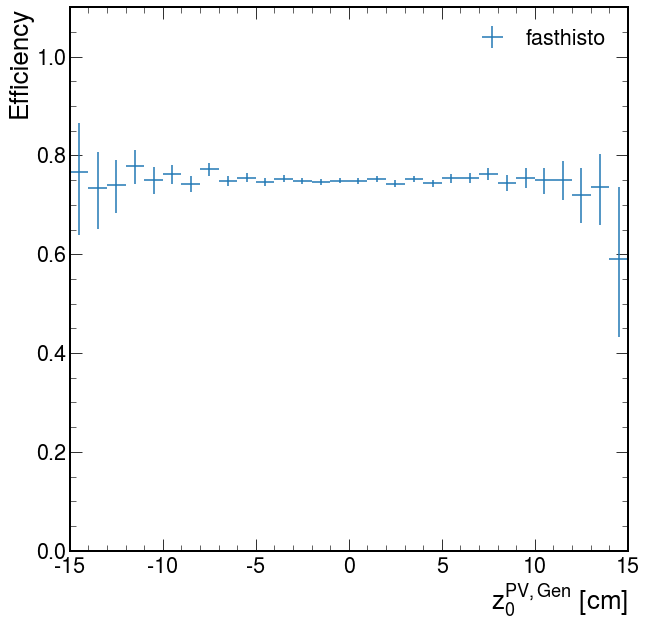

In [401]:
fh = pm.plot_pv_efficiency_z0(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_fh_cor, label="fasthisto"
)

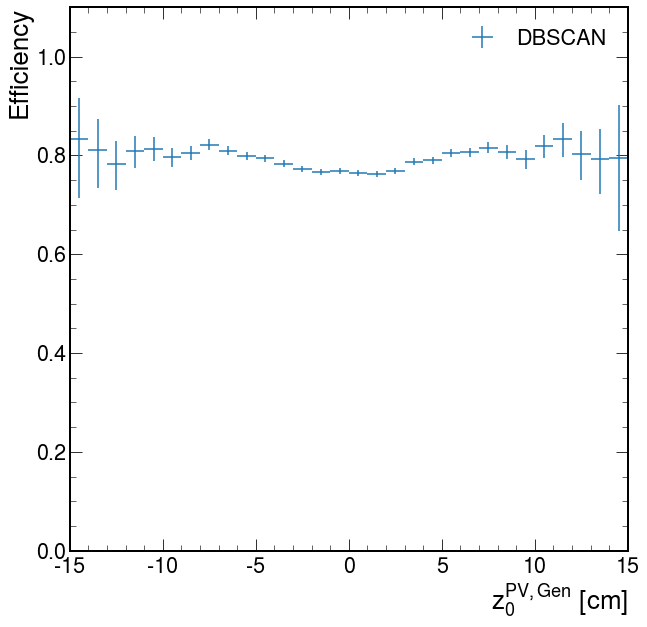

In [402]:
db = pm.plot_pv_efficiency_z0(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_db_cor, label="DBSCAN"
)

In [403]:
print("hi")

hi


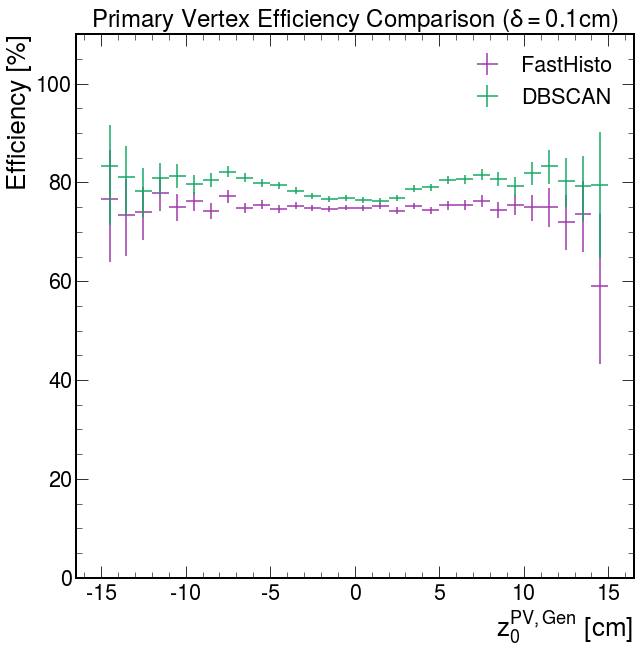

In [410]:
compare_efficiency_z0(fh, db, filename="DB_FHV2_pv_eff_z0.pdf")

## 3. Primary Vertex Resolution Histogram

In [311]:
help(pm.pv_resolution)

Help on method pv_resolution in module __main__:

pv_resolution(z0_gen: <built-in function array>, z0_reco: <built-in function array>, bins: <built-in function array> = None, label: str = None, title: str = 'Primary Vertex Resolution', xlim: list = None) method of __main__.PerformanceMetrics instance



In [412]:
res_bins = np.linspace(-5, 5, 100)

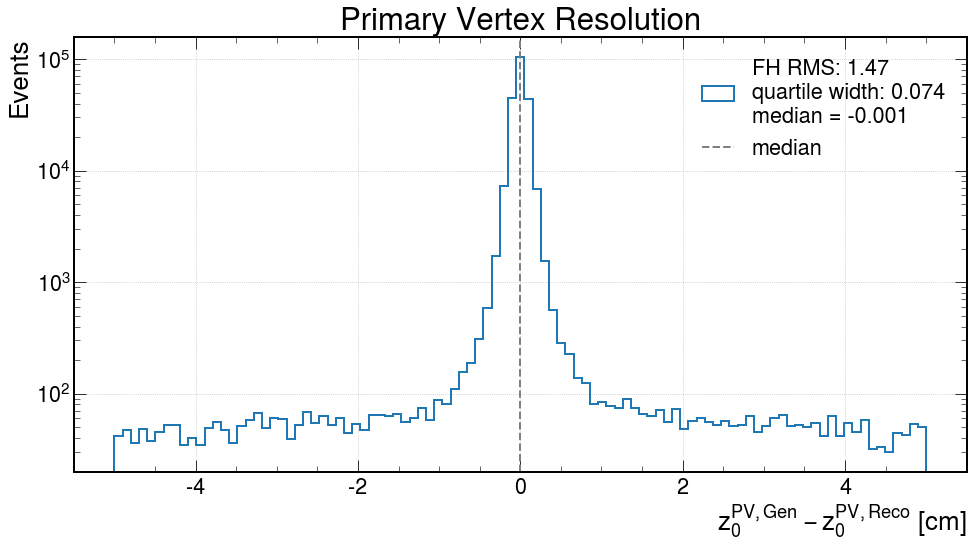

In [413]:
fh = pm.pv_resolution(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_fh_cor, bins=res_bins, label="FH "
)

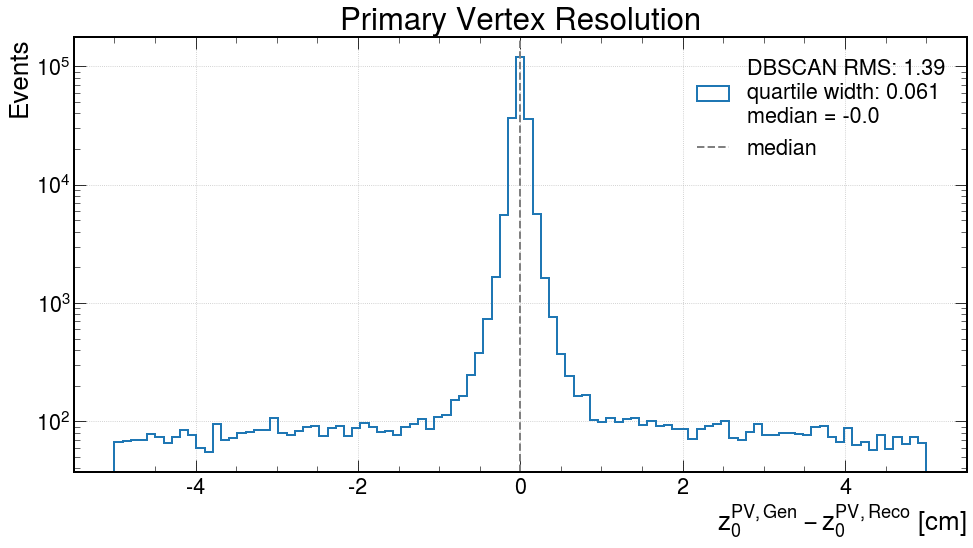

In [414]:
db = pm.pv_resolution(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_db_cor, bins=res_bins, label="DBSCAN "
)

In [415]:
def compare_resolution_histogram(obj1: dict, obj2: dict, filename: str = None):

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    hep.histplot(
        obj1["hist"], obj1["bins"], label=obj1["label"], ax=ax, color="#9E37AD"
    )

    hep.histplot(
        obj2["hist"], obj2["bins"], label=obj2["label"], ax=ax, color="#12A863"
    )

    ax.set_yscale("log")
    ax.set_xlabel(r"$z_0^{PV, Gen} - z_0^{PV, Reco}$ [cm]")
    ax.set_ylabel("Entries")
    ax.legend()
    if filename is not None:
        plt.savefig(filename, dpi=600, bbox_inches="tight")

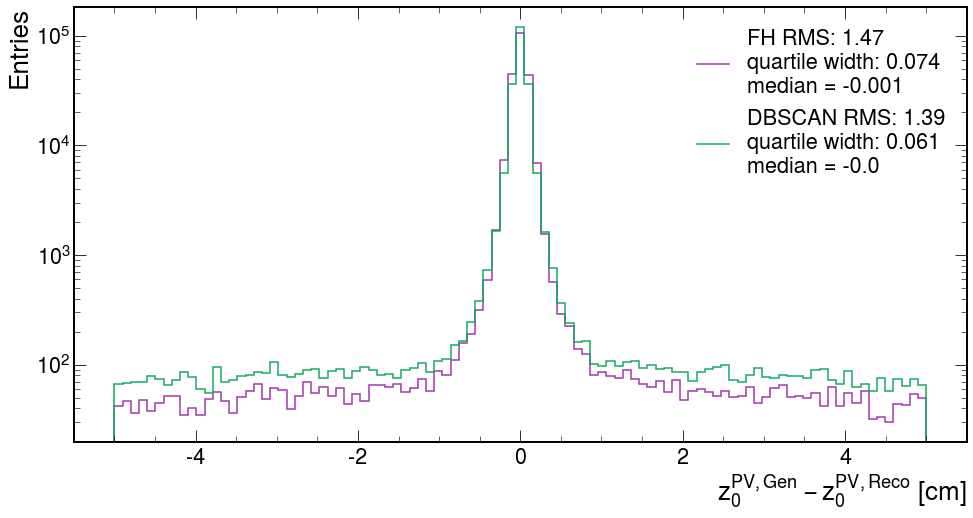

In [418]:
compare_resolution_histogram(fh, db, filename="DB_FHV2_res_histo.pdf")

## 4. Primary vertex resolution vs z0

In [317]:
help(pm.plot_pv_resolution_z0)

Help on method plot_pv_resolution_z0 in module __main__:

plot_pv_resolution_z0(z0_reco: <built-in function array> = None, z0_gen: <built-in function array> = None, bins=None, label=None) method of __main__.PerformanceMetrics instance



In [419]:
bins_profile = np.arange(-15, 16, 1)

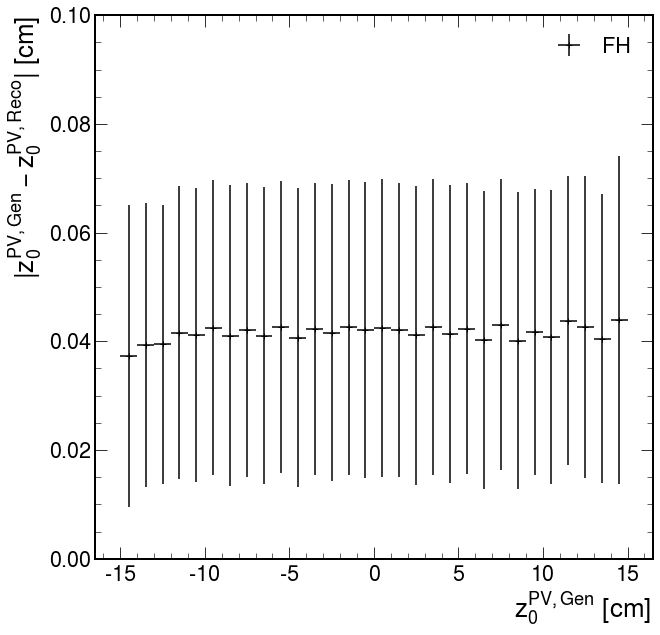

In [420]:
fh = pm.plot_pv_resolution_z0(
    z0_reco=pm.z0_reco_fh_cor, z0_gen=pm.z0_gen, bins=bins_profile, label="FH"
)

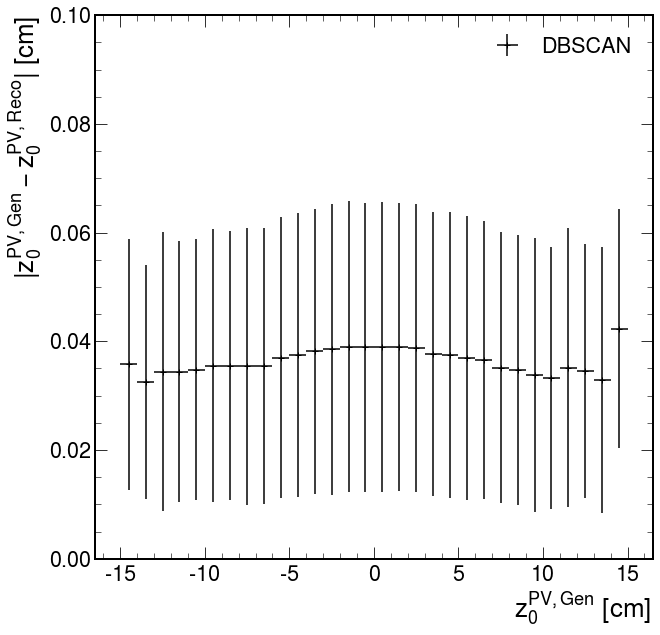

In [421]:
db = pm.plot_pv_resolution_z0(
    z0_reco=pm.z0_reco_db_cor, z0_gen=pm.z0_gen, bins=bins_profile, label="DBSCAN"
)

In [423]:
def compare_resolution_z0(obj1, obj2, filename: str = None):

    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    ax[0].errorbar(
        obj1["x"],
        obj1["mean_res"],
        xerr=obj1["xerr"],
        yerr=obj1["yerr"],
        ls="none",
        label=obj1["label"],
        color="#9E37AD",
    )
    ax[1].errorbar(
        obj2["x"],
        obj2["mean_res"],
        xerr=obj2["xerr"],
        yerr=obj2["yerr"],
        ls="none",
        label=obj2["label"],
        color="#12A863",
    )
    plt.subplots_adjust(wspace=0.01)
    ax[0].set_xlabel(r"$z^{PV}_{gen}$ [cm]")
    ax[1].set_xlabel(r"$z^{PV}_{gen}$ [cm]")
    ax[0].set_ylabel(r"$|z^{PV}_{gen} - z^{PV}_{reco}|$ [cm]")
    ax[0].set_title(obj1["label"])
    ax[1].set_title(obj2["label"])
    if filename is not None:
        plt.savefig(filename, dpi=500, bbox_inches="tight")

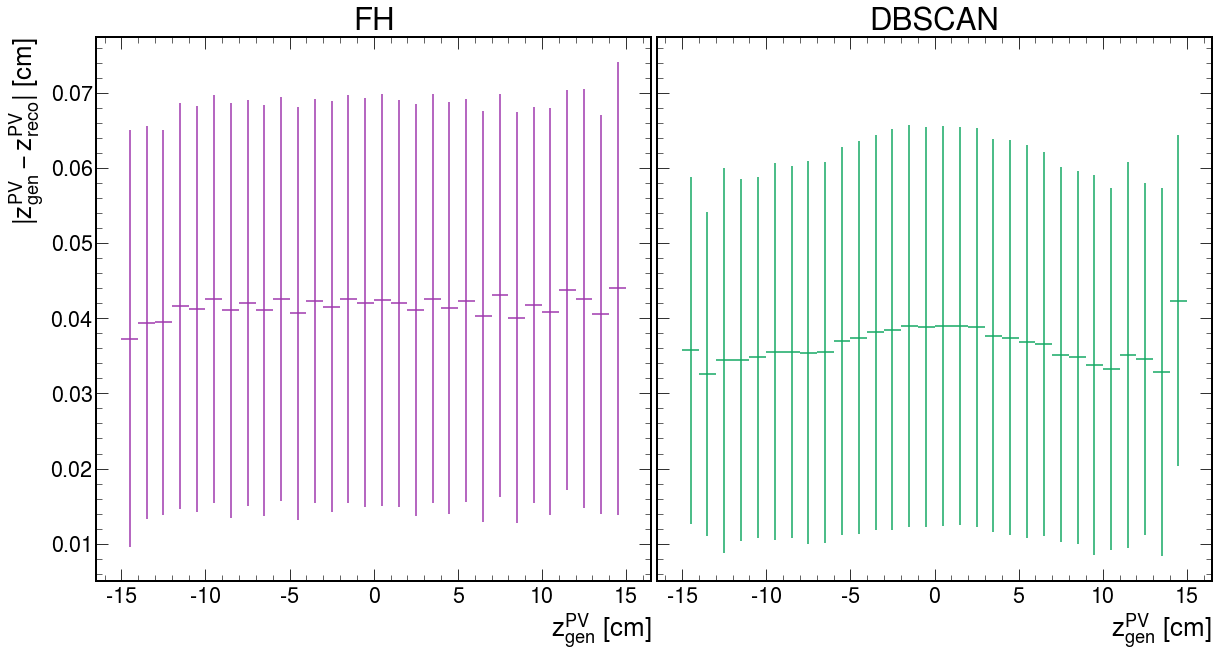

In [424]:
compare_resolution_z0(fh, db, filename="DB_FHV2_res_z0.pdf")

## 7. TRP FPR (classification metrics)

In [272]:
fh_bias = 0.118798494
db_positive_bias = 0.034397364
db_negative_bias = -0.034312308

In [322]:
pm.trk["distance_from_pv_fh"] = np.abs(pm.trk["z0_reco_fh_cor"] - pm.trk["trk_z0"])

In [323]:
pm.trk["trk_pv_assoc_fh2"] = pv.fh_pv_association(
    pm.trk["distance_from_pv_fh"], pm.trk["trk_eta"]
)

In [324]:
fh_metrics = pm.trk_vertex_association(
    pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_fh2"].values
)
print(fh_metrics)

{'tn': 29627251, 'fp': 4957474, 'fn': 454563, 'tp': 5741352, 'TPR': 0.9266350490605504, 'FPR': 0.14334287752757902, 'AUC': 0.8916460857664856}


In [325]:
db_metrics = pm.trk_vertex_association(
    pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_db"].values
)
print(db_metrics)

{'tn': 32458244, 'fp': 2126481, 'fn': 1307615, 'tp': 4888300, 'TPR': 0.7889553036153659, 'FPR': 0.061486132967661304, 'AUC': 0.8637345853238523}


In [326]:
pm.trk["distance_from_pv_db"] = np.abs(pm.trk["z0_reco_db_cor"] - pm.trk["trk_z0"])
pm.trk["trk_pv_assoc_db2"] = pv.fh_pv_association(
    pm.trk["distance_from_pv_db"], pm.trk["trk_eta"]
)

In [327]:
db_metrics2 = pm.trk_vertex_association(
    pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_db2"].values
)
print(db_metrics2)

{'tn': 29440219, 'fp': 5144506, 'fn': 457573, 'tp': 5738342, 'TPR': 0.9261492451074619, 'FPR': 0.14875081412386537, 'AUC': 0.8886992154917983}


# 6. Confusion Matrix

In [328]:
from sklearn.metrics import confusion_matrix
from pv_utils import make_confusion_matrix

In [329]:
labels = ["TN", "FP", "FN", "TP"]
categories = ["Primary Vertex", "Not Primary Vertex"]

In [330]:
cf_fh = confusion_matrix(pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_fh2"].values)
cf_db = confusion_matrix(pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_db2"].values)

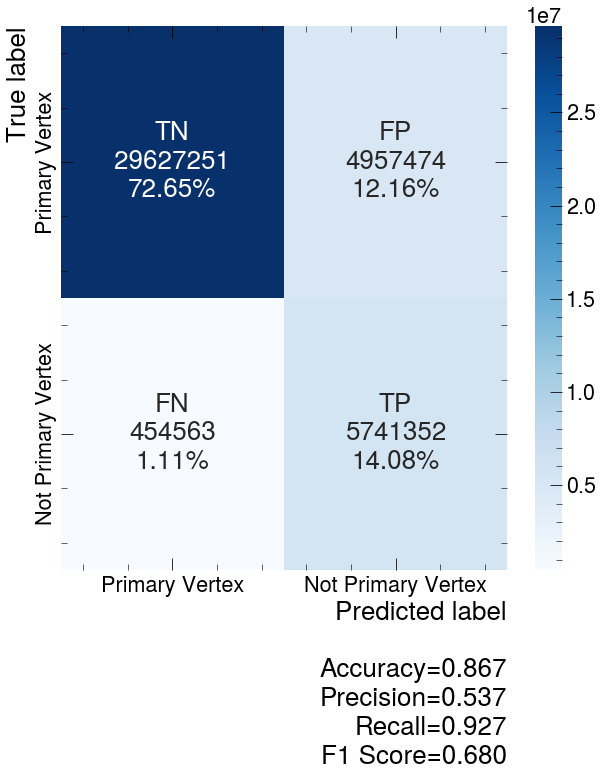

In [427]:
make_confusion_matrix(cf_fh, group_names=labels, categories=categories)
plt.savefig("FHV2_CM.pdf", dpi=600, bbox_inches="tight")

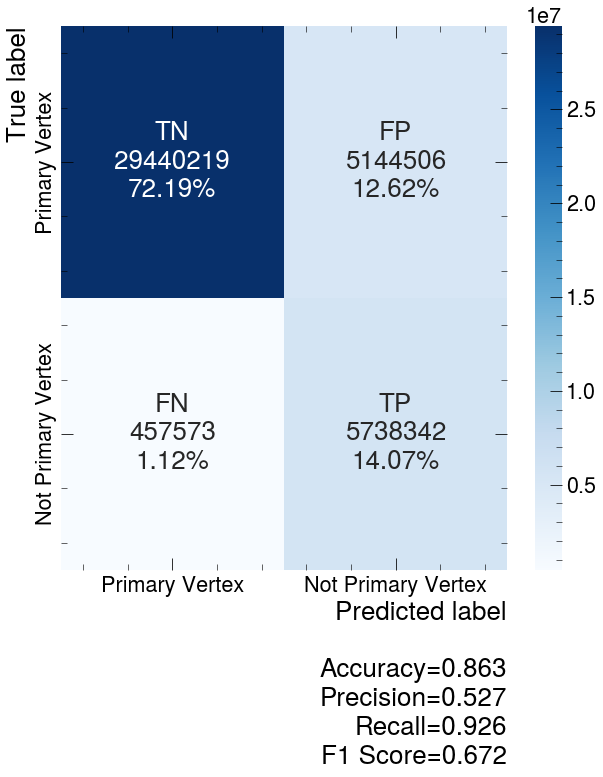

In [428]:
make_confusion_matrix(cf_db, group_names=labels, categories=categories)
plt.savefig("DB_CM.pdf", dpi=600, bbox_inches="tight")

 ## 7. TPR, FPR vs z0

In [367]:
pm.mc

,,pv_L1reco_z0,pv_L1reco_sum,pv_MC
entry,subentry,,,
0,0,5.026911,79.777252,5.055163
1,0,-2.021080,90.041313,-3.608661
2,0,-0.141508,202.421341,-0.261453
3,0,2.744174,303.983124,2.803285
4,0,-1.279072,218.012939,-1.400667
...,...,...,...,...
222971,0,-0.672085,223.375061,-0.698029
222972,0,0.576154,121.422821,0.520282
222973,0,-3.504717,167.360825,-3.604865


In [370]:
index = pm.trk.index

In [374]:
pv_MC_trk = pm.mc.reindex(index).ffill()["pv_MC"].values

In [375]:
pm.trk["pv_MC"] = pv_MC_trk

In [376]:
pm.trk.head()

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   

                is_pv  z0_reco_fh  distance_from_pv_fh  trk_pv_assoc_fh  \
entry subentry                                                            
0     0             0    4.863511             5.861216              0.0   
      1             0    4.863511             1.642466              0.0   
      2             1    4.863511             0.060434              1.0   
      3             0    4.863511             5.451059              0.0   
      4             1    4.863511             0.001841              1.0   

                z0_reco_db  trk_pv_assoc_db  distance_from_pv_db  \
entry subentry                                                     
0     0           4.980469                0             5.893772   
      1           4.980469                0             1.675022   
      2           4.980469                1             0.092991   
      3           4.980469                0             5.483616   
      4           4.980469                1             0.034397   

                trk_pv_assoc_db2  trk_pv_assoc_fh2  event_number  \
entry subentry                                                     
0     0                      0.0               0.0             0   
      1                      0.0               0.0             0   
      2                      1.0               1.0             0   
      3                      0.0               0.0             0   
      4                      1.0               1.0             0   

                z0_reco_fh_cor  z0_reco_db_cor     pv_MC  
entry subentry                                            
0     0               4.982309        5.014866  5.055163  
      1               4.982309        5.014866  5.055163  
      2               4.982309        5.014866  5.055163  
      3               4.982309        5.014866  5.055163  
      4               4.982309        5.014866  5.055163

In [377]:
bw = 1
z0_bins = np.arange(-15, 15 + bw, bw)
x = 0.5 * (z0_bins[1:] + z0_bins[:-1])
TPRS_fh = []
FPRS_fh = []
TPRS_db = []
FPRS_db = []

for z0_bin in z0_bins[:-1]:
    print(z0_bin)
    mask = (pm.trk.pv_MC > z0_bin) & (pm.trk.pv_MC < z0_bin + bw)

    y_true = pm.trk.loc[mask, "is_pv"]
    y_pred_fh = pm.trk.loc[mask, "trk_pv_assoc_fh2"]
    y_pred_db = pm.trk.loc[mask, "trk_pv_assoc_db2"]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_fh).ravel()
    TPR = tp / (tp + fn)
    FPR = fp / (tn + fp)

    TPRS_fh.append(TPR)
    FPRS_fh.append(FPR)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_db).ravel()

    TPR = tp / (tp + fn)
    FPR = fp / (tn + fp)

    TPRS_db.append(TPR)
    FPRS_db.append(FPR)

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


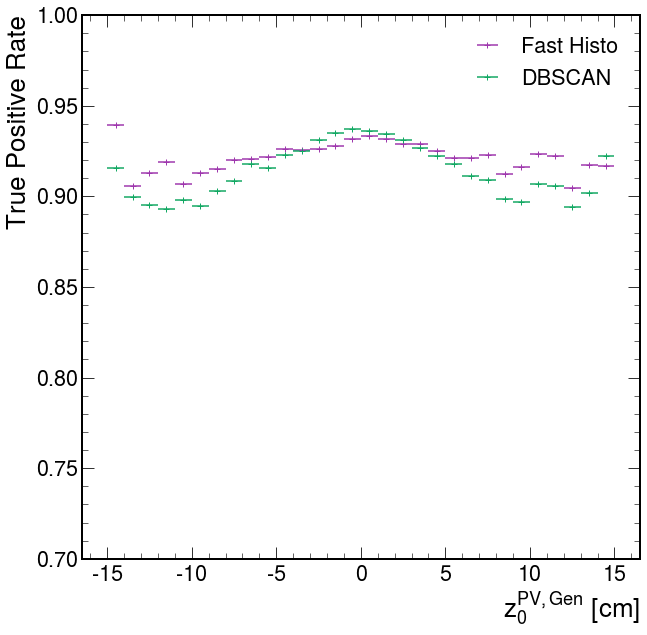

In [429]:
xerr = pm.bin_width_error(z0_bins)
plt.errorbar(
    x, TPRS_fh, fmt="+", label="Fast Histo", color="#9E37AD", xerr=xerr, ls="none"
)
plt.errorbar(x, TPRS_db, fmt="+", label="DBSCAN", color="#12A863", xerr=xerr, ls="none")
plt.legend()
plt.xlabel(r"$z_0^{PV, Gen}$ [cm]")
plt.ylabel("True Positive Rate")
plt.ylim(0.7, 1)
plt.savefig("DB_FHV2_TPR_z0.pdf", dpi=600, bbox_inches="tight")

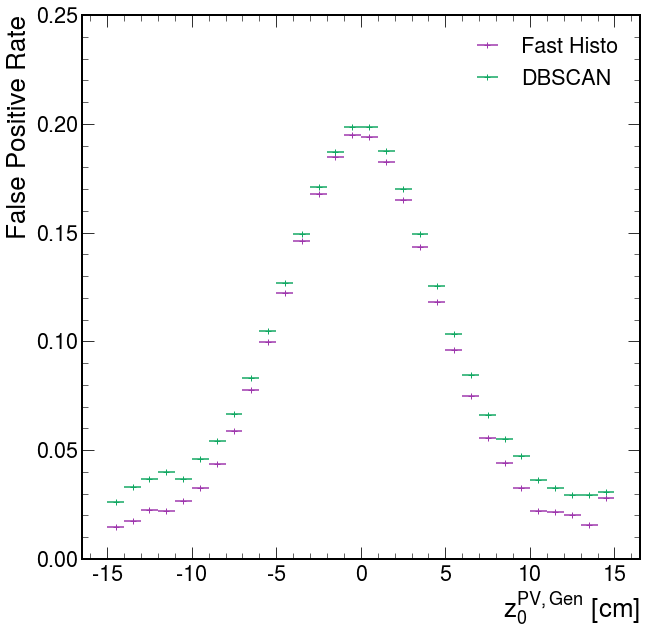

In [430]:
xerr = pm.bin_width_error(z0_bins)
plt.errorbar(
    x, FPRS_fh, fmt="+", label="Fast Histo", color="#9E37AD", xerr=xerr, ls="none"
)
plt.errorbar(x, FPRS_db, fmt="+", label="DBSCAN", color="#12A863", xerr=xerr, ls="none")
plt.legend()
plt.xlabel(r"$z_0^{PV, Gen}$ [cm]")
plt.ylabel("False Positive Rate")
plt.ylim(0, 0.25)
plt.savefig("DB_FHV2_FPR_z0.pdf", dpi=600, bbox_inches="tight")

# BIASES STUDIES

## Fast Histo Bias

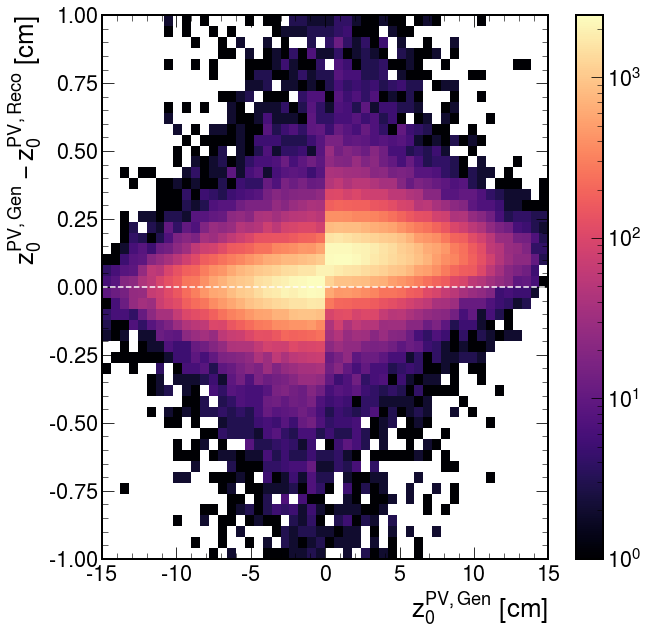

In [431]:
pm.res_vs_z0(pm.res_fh, pm.z0_gen, hrange=((-15, 15), (-1, 1)), dolog=True)
plt.axhline(0, ls="--", color="white")
plt.savefig("FHV2_hist2d_bias.pdf", dpi=600, bbox_inches="tight")

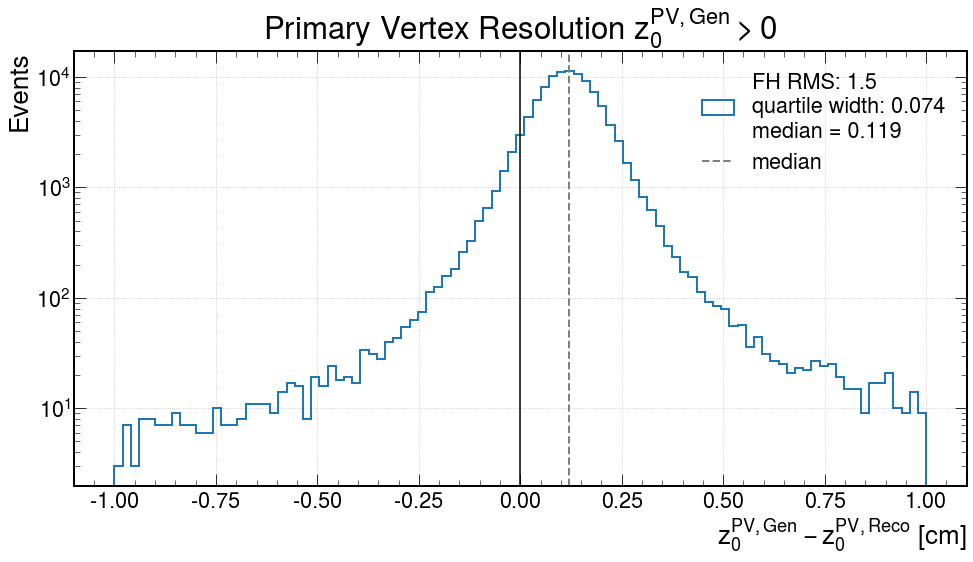

In [432]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen > 0],
    z0_reco=pm.z0_reco_fh[pm.z0_gen > 0],
    bins=np.linspace(-1, 1, 100),
    label="FH ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} >0$",
)
plt.axvline(0, color="black")
plt.savefig("FHV2_res_hist_positive_bias.pdf", dpi=600, bbox_inches="tight")

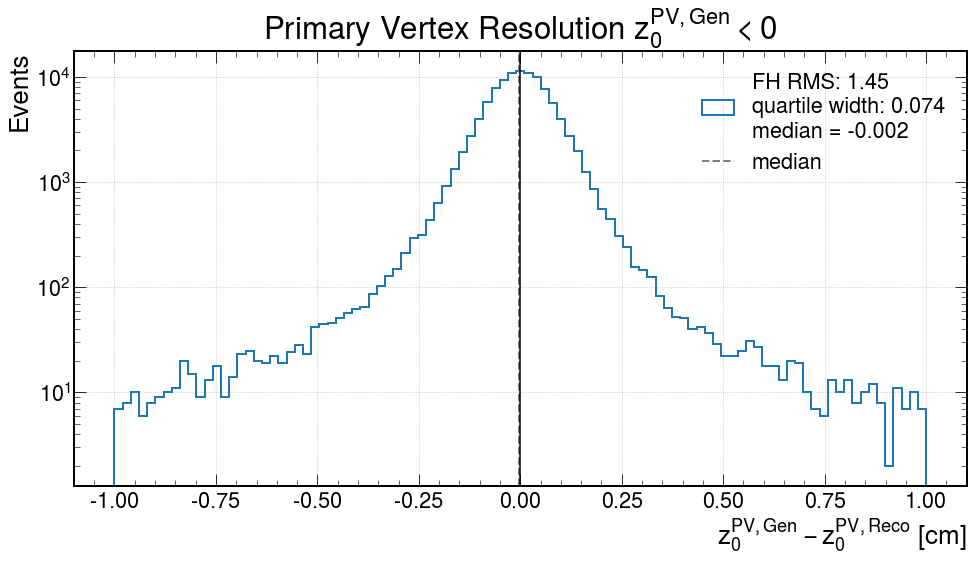

In [433]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen < 0],
    z0_reco=pm.z0_reco_fh[pm.z0_gen < 0],
    bins=np.linspace(-1, 1, 100),
    label="FH ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} < 0$",
)
plt.axvline(0, color="black")
plt.savefig("FHV2_res_hist_negative_bias.pdf", dpi=600, bbox_inches="tight")

## FastHisto Post correction

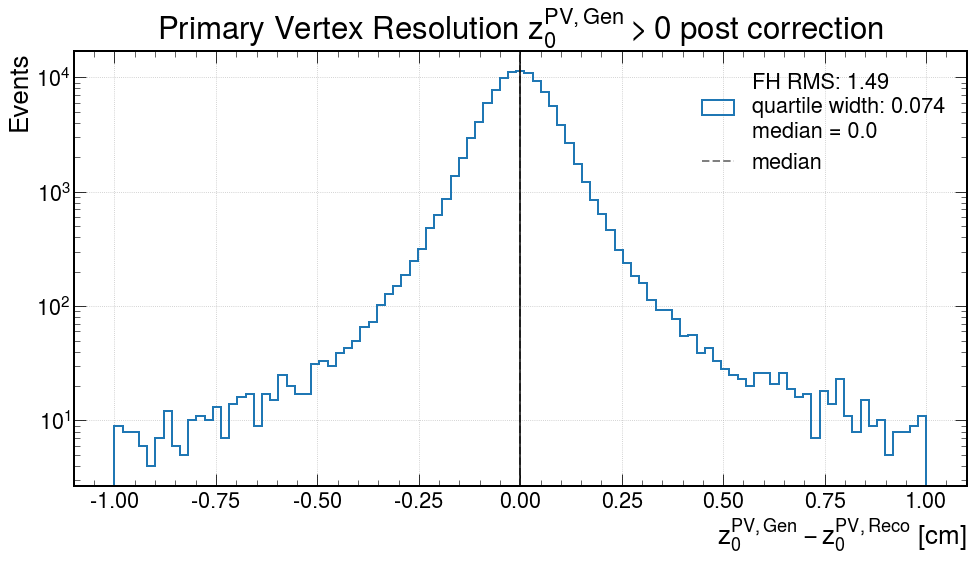

In [434]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen > 0],
    z0_reco=pm.z0_reco_fh_cor[pm.z0_gen > 0],
    bins=np.linspace(-1, 1, 100),
    label="FH ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} >0$ post correction",
)
plt.axvline(0, color="black")
plt.savefig("FHV2_res_hist_positive_bias_corrected.pdf", dpi=600, bbox_inches="tight")

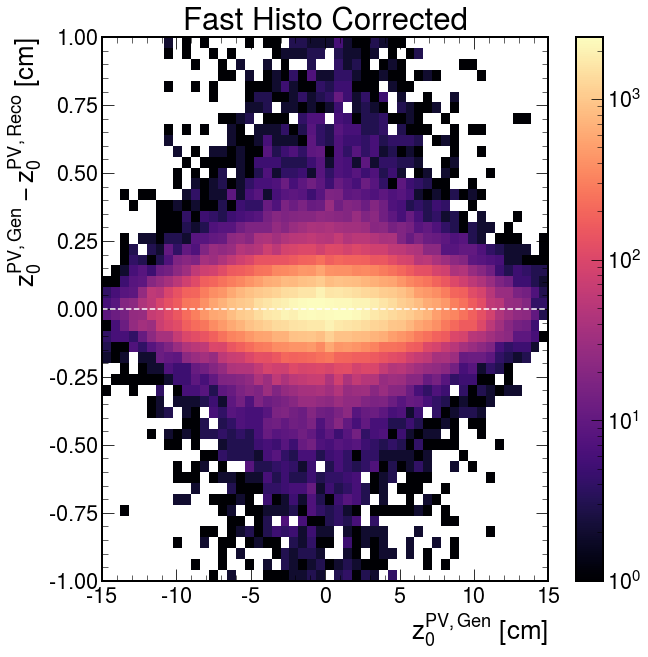

In [435]:
pm.res_vs_z0(
    (pm.z0_gen - pm.z0_reco_fh_cor), pm.z0_gen, hrange=((-15, 15), (-1, 1)), dolog=True
)
plt.axhline(0, ls="--", color="white")
plt.title("Fast Histo Corrected")
plt.savefig("FHV2_hist2d_bias_corrected.pdf", dpi=600, bbox_inches="tight")

## DBSCAN BIAS

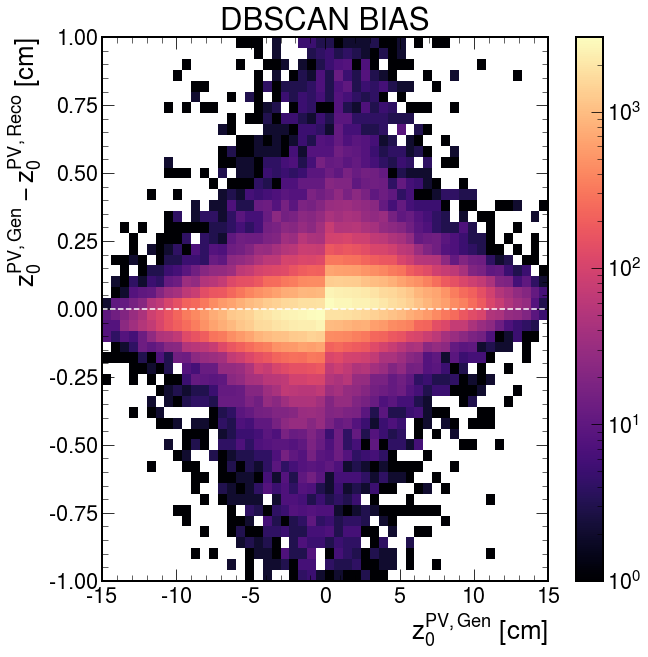

In [436]:
pm.res_vs_z0(
    (pm.z0_gen - pm.z0_reco_db), pm.z0_gen, hrange=((-15, 15), (-1, 1)), dolog=True
)
plt.axhline(0, ls="--", color="white")
plt.title("DBSCAN BIAS")
plt.savefig("DBSCAN_hist2d_bias.pdf", dpi=600, bbox_inches="tight")

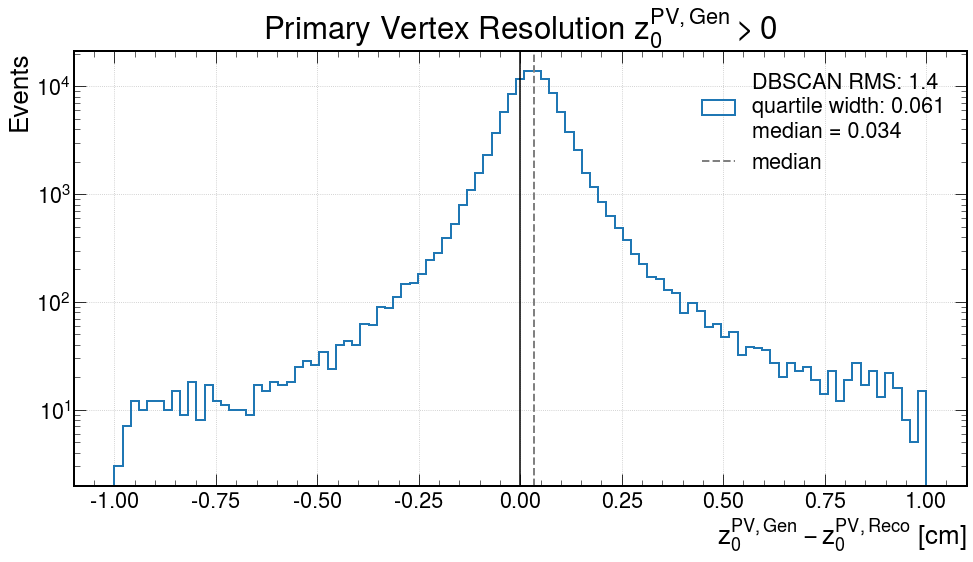

In [437]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen > 0],
    z0_reco=pm.z0_reco_db[pm.z0_gen > 0],
    bins=np.linspace(-1, 1, 100),
    label="DBSCAN ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} >0$",
)
plt.axvline(0, color="black")
plt.savefig("DBSCAN_res_hist_positive_bias.pdf", dpi=600, bbox_inches="tight")

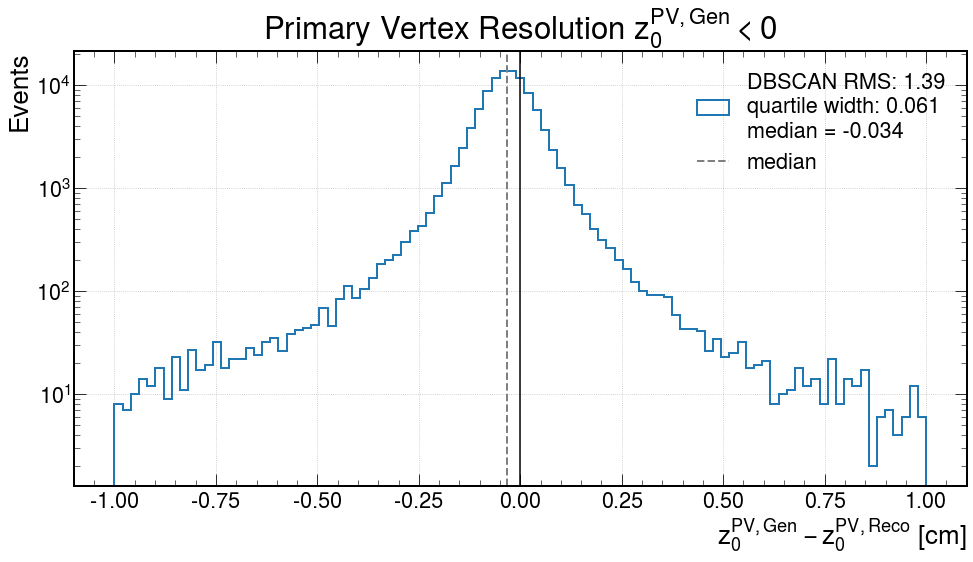

In [438]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen < 0],
    z0_reco=pm.z0_reco_db[pm.z0_gen < 0],
    bins=np.linspace(-1, 1, 100),
    label="DBSCAN ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} <0$",
)
plt.axvline(0, color="black")
plt.savefig("DBSCAN_res_hist_negative_bias.pdf", dpi=600, bbox_inches="tight")

## DBSCAN post correction

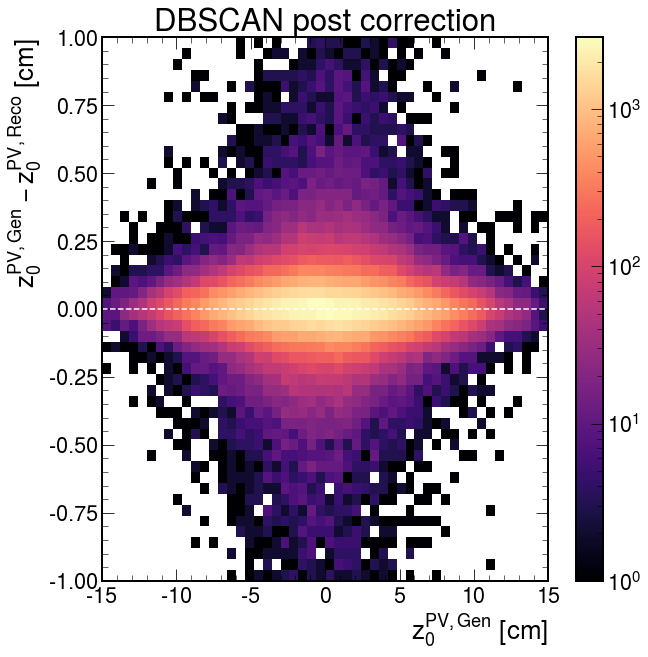

In [439]:
pm.res_vs_z0(
    (pm.z0_gen - pm.z0_reco_db_cor), pm.z0_gen, hrange=((-15, 15), (-1, 1)), dolog=True
)
plt.axhline(0, ls="--", color="white")
plt.title("DBSCAN post correction")
plt.savefig("DBSCAN_hist2d_bias_corrected.pdf", dpi=600, bbox_inches="tight")

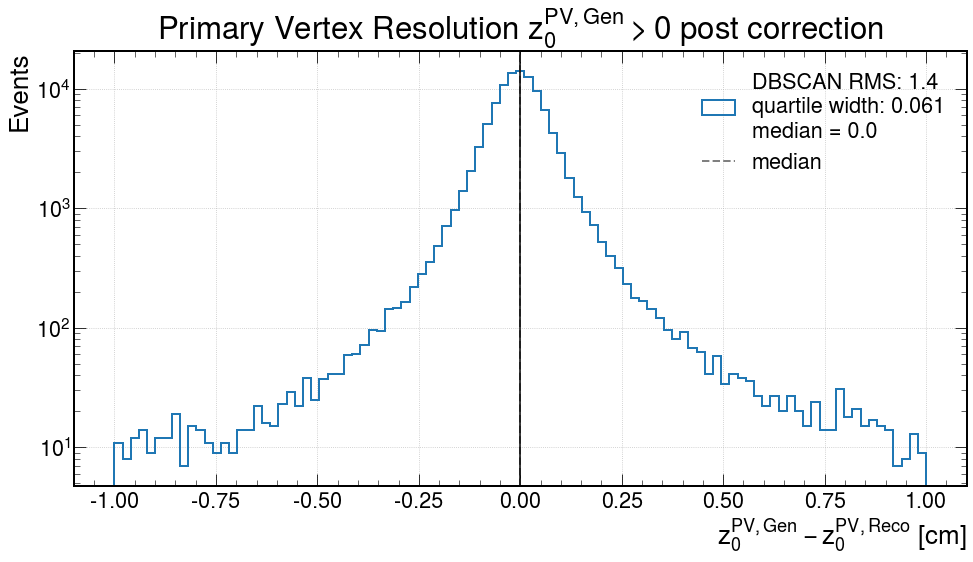

In [440]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen > 0],
    z0_reco=pm.z0_reco_db_cor[pm.z0_gen > 0],
    bins=np.linspace(-1, 1, 100),
    label="DBSCAN ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} >0$ post correction",
)
plt.axvline(0, color="black")
plt.savefig("DBSCAN_res_hist_positive_bias_corrected.pdf", dpi=600, bbox_inches="tight")

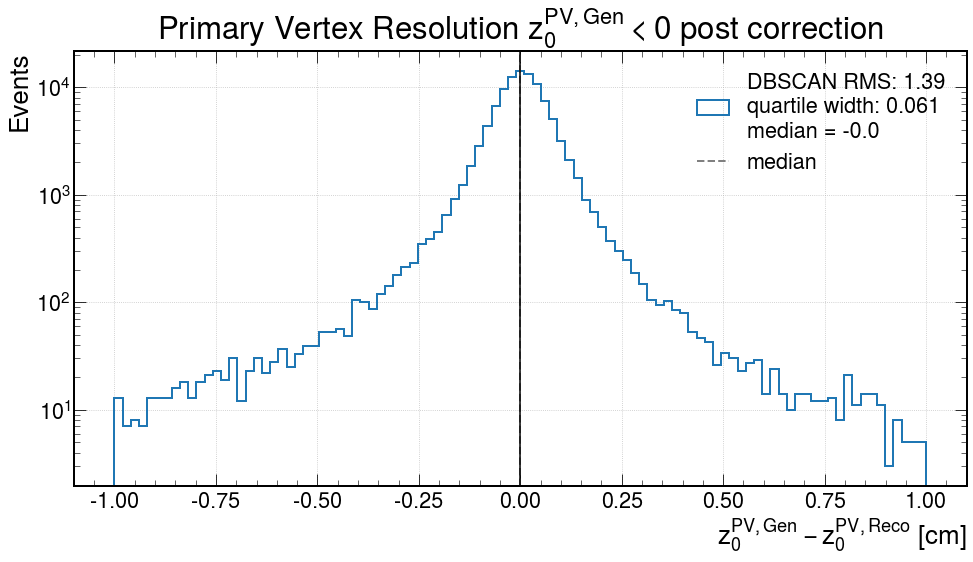

In [441]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen < 0],
    z0_reco=pm.z0_reco_db_cor[pm.z0_gen < 0],
    bins=np.linspace(-1, 1, 100),
    label="DBSCAN ",
    title="Primary Vertex Resolution $z_0^{PV,Gen} < 0$ post correction",
)
plt.axvline(0, color="black")
plt.savefig("DBSCAN_res_hist_negative_bias_corrected.pdf", dpi=600, bbox_inches="tight")

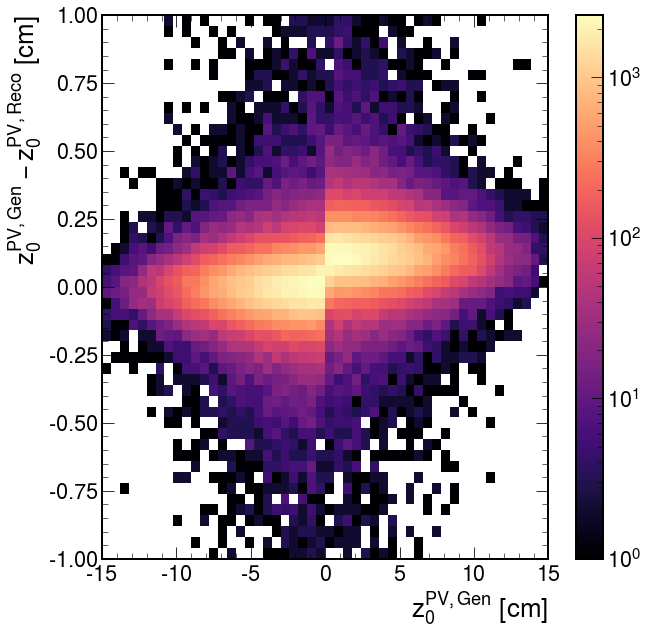

In [282]:
pm.res_vs_z0(pm.res_fh, pm.z0_gen, hrange=((-15, 15), (-1, 1)), dolog=True)

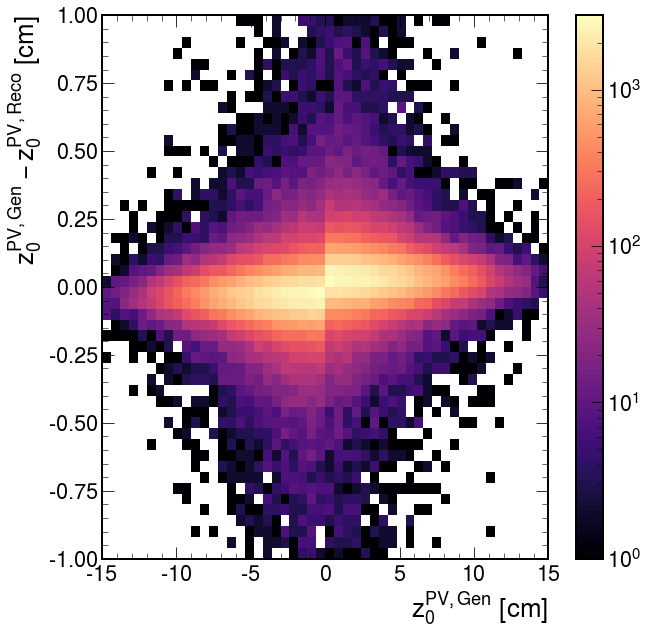

In [174]:
pm.res_vs_z0(
    res=(pm.z0_gen - pm.z0_reco_db),
    z0_gen=pm.z0_gen,
    hrange=((-15, 15), (-1, 1)),
    dolog=True,
)

array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
       -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
       -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
       -1.93877551, -1.73469388, -1.53061224, -1.32653061, -1.12244898,
       -0.91836735, -0.71428571, -0.51020408, -0.30612245, -0.10204082,
        0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
        1.12244898,  1.32653061,  1.53061224,  1.73469388,  1.93877551,
        2.14285714,  2.34693878,  2.55102041,  2.75510204,  2.95918367,
        3.16326531,  3.36734694,  3.57142857,  3.7755102 ,  3.97959184,
        4.18367347,  4.3877551 ,  4.59183673,  4.79591837,  5.        ])

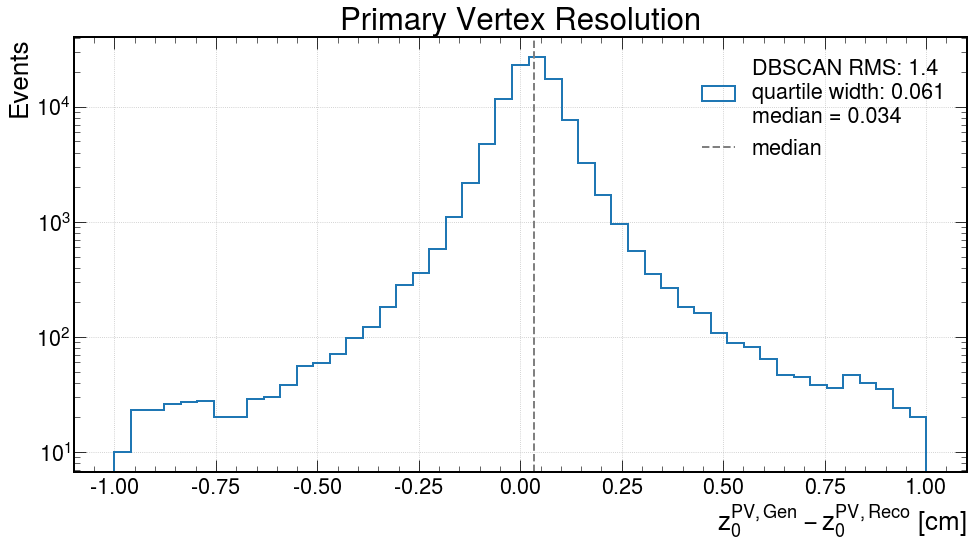

In [210]:
_ = pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen > 0],
    z0_reco=pm.z0_reco_db[pm.z0_gen > 0],
    bins=np.linspace(-1, 1, 50),
    label="DBSCAN ",
)

In [179]:
mask = pm.z0_gen > 0

np.median(pm.z0_gen[mask] - pm.z0_reco_db[mask])

0.034397364

{'hist': array([1.3500e+02, 1.3200e+02, 1.3400e+02, 1.2200e+02, 1.3800e+02,
        1.1600e+02, 1.2600e+02, 1.3900e+02, 1.4600e+02, 1.7000e+02,
        1.3500e+02, 1.3800e+02, 1.2900e+02, 1.3600e+02, 1.2900e+02,
        1.3100e+02, 1.1300e+02, 1.2100e+02, 1.3000e+02, 1.2700e+02,
        1.8700e+02, 3.2600e+02, 1.1210e+03, 1.4076e+04, 8.4677e+04,
        4.5100e+03, 5.6400e+02, 1.7700e+02, 1.1200e+02, 8.7000e+01,
        6.2000e+01, 5.7000e+01, 5.0000e+01, 5.2000e+01, 3.7000e+01,
        4.5000e+01, 3.5000e+01, 2.8000e+01, 2.7000e+01, 1.7000e+01,
        2.5000e+01, 2.2000e+01, 2.2000e+01, 1.7000e+01, 1.9000e+01,
        8.0000e+00, 1.2000e+01, 1.1000e+01, 9.0000e+00]),
 'bins': array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
        -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
        -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
        -1.93877551, -1.73469388, -1.53061224, -1.32653061, -1.12244898,
        -0.91836735, -

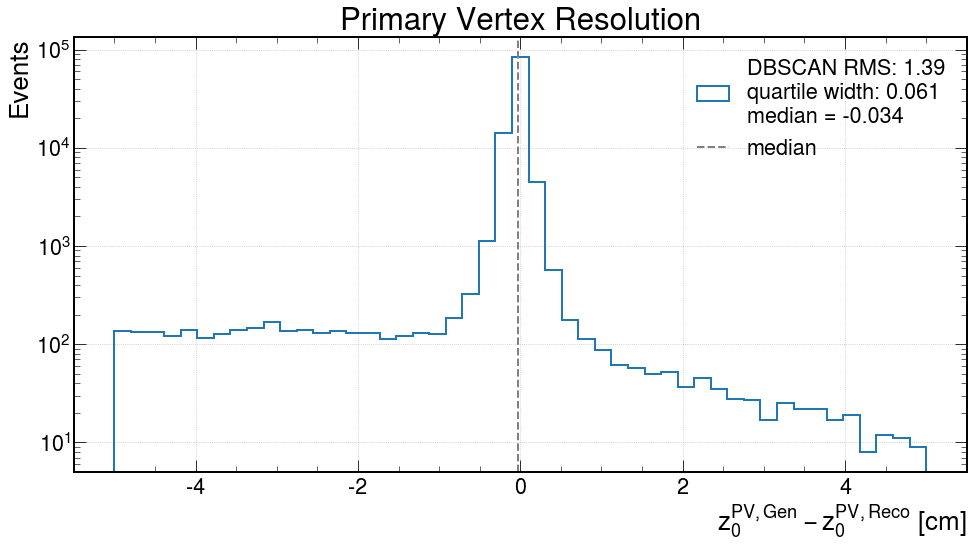

In [177]:
pm.pv_resolution(
    z0_gen=pm.z0_gen[pm.z0_gen < 0],
    z0_reco=pm.z0_reco_db[pm.z0_gen < 0],
    bins=res_bins,
    label="DBSCAN ",
    xlim=
)

{'x': array([-14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,
         -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,
          3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,
         12.5,  13.5,  14.5]),
 'mean_res': array([0.04416762, 0.04073952, 0.0410714 , 0.03868376, 0.03987278,
        0.03801695, 0.04075074, 0.03981366, 0.04005818, 0.04092438,
        0.04166361, 0.04151535, 0.04141663, 0.0421082 , 0.04166503,
        0.0420943 , 0.04198848, 0.04173819, 0.04134618, 0.0410035 ,
        0.04094806, 0.04037646, 0.03990963, 0.03874188, 0.03900656,
        0.03950714, 0.03838841, 0.03824005, 0.035195  , 0.04106282]),
 'xerr': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5]),
 'yerr': array([0.03184967, 0.02589424, 0.02502993, 0.02641281, 0.02669305,
        0.0259008 , 0.02690698, 0.02621938, 0.02664068, 0.0266752 ,
 

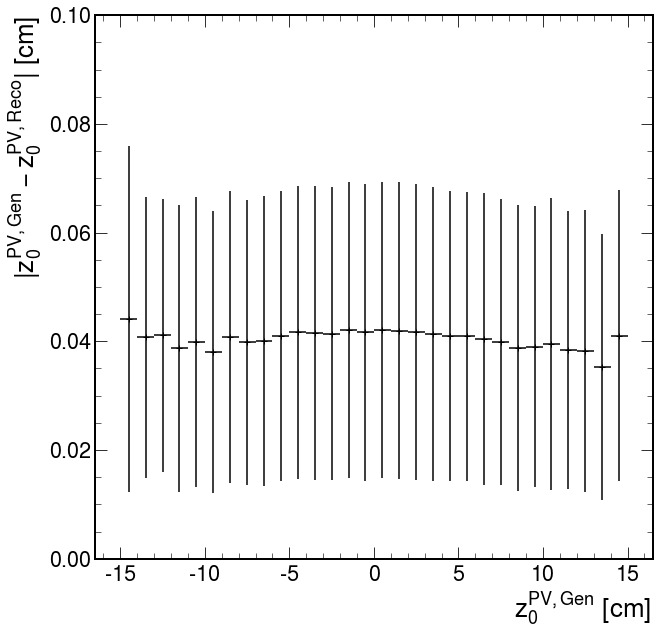

In [175]:
pm.plot_pv_resolution_z0(pm.z0_reco_db)

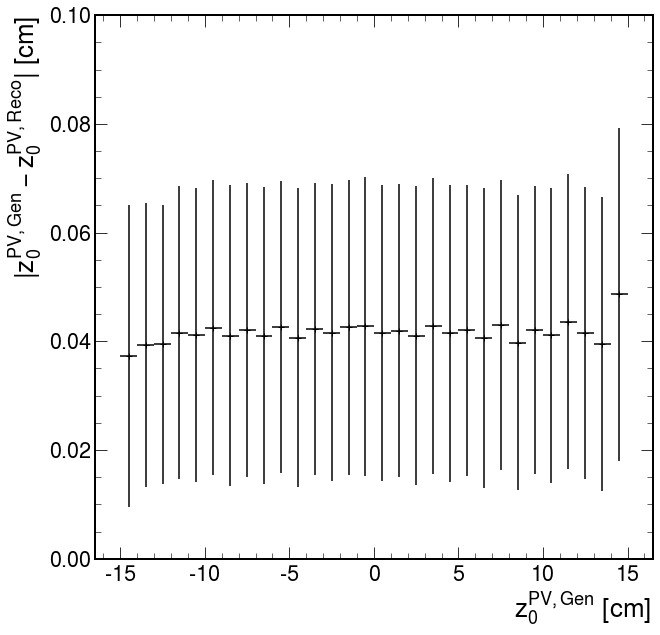

In [286]:
pm.plot_pv_resolution_z0(z0_gen=pm.z0_gen_cor, z0_reco=pm.z0_reco_fh)

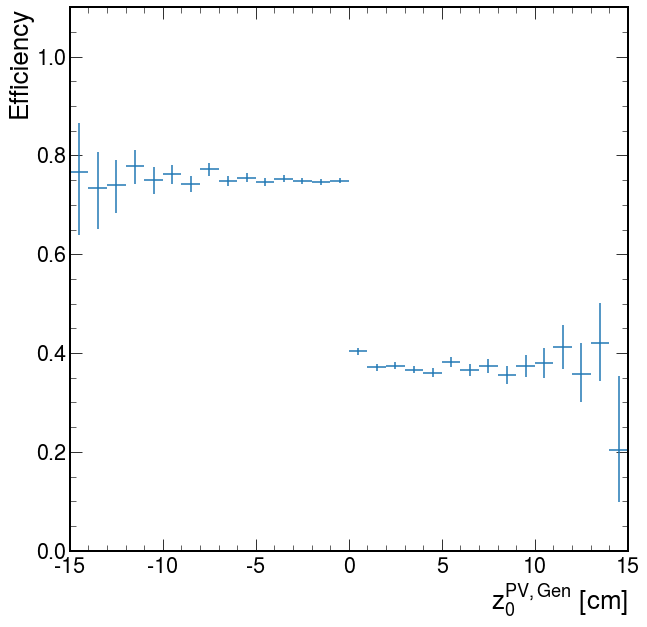

In [279]:
pm.plot_pv_efficiency_z0(pm.z0_gen, pm.z0_reco_fh)

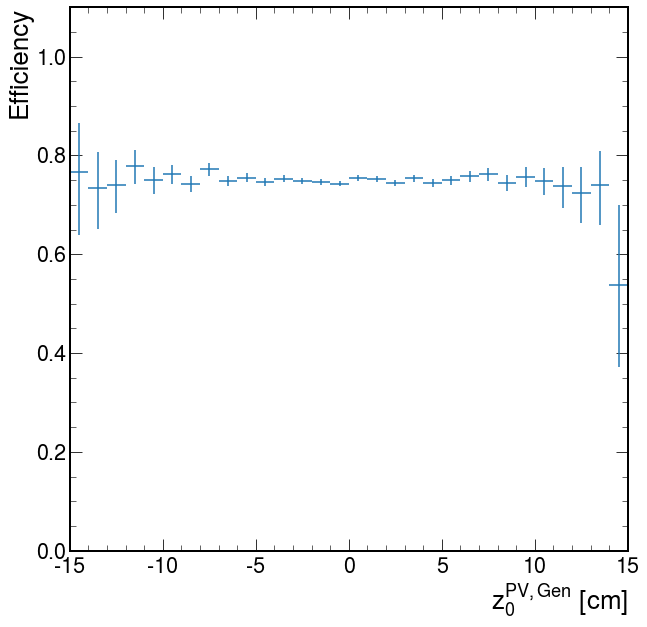

In [280]:
pm.plot_pv_efficiency_z0(z0_gen=pm.z0_gen_cor, z0_reco=pm.z0_reco_fh)

In [247]:
np.median(pm.z0_gen_cor)

-0.059837304

In [248]:
np.median(pm.z0_gen)

-0.00072641973

In [249]:
np.median(pm.z0_gen[pm.z0_gen > 0] - pm.z0_reco_fh[pm.z0_gen > 0])

0.118798494

In [252]:
np.median(pm.z0_gen[pm.z0_gen < 0] - pm.z0_reco_fh[pm.z0_gen < 0])

-0.0019552708

In [250]:
np.median(pm.z0_gen_cor[pm.z0_gen_cor > 0] - pm.z0_reco_fh[pm.z0_gen_cor > 0])

0.0011100769

In [251]:
np.median(pm.z0_gen_cor[pm.z0_gen_cor < 0] - pm.z0_reco_fh[pm.z0_gen_cor < 0])

-0.002947569

In [121]:
pv.fh_classification_metrics

{'tn': 29615833,
 'fp': 4968892,
 'fn': 454632,
 'tp': 5741283,
 'TPR': 0.9266239126908616,
 'FPR': 0.14367302327834036,
 'AUC': 0.8914754447062607}

In [122]:
accuracy_score(pv.trk["is_pv"], trk["trk_pv_assoc_fh"])

0.8670073838958878

In [293]:
pv.mc[(pv.mc["pv_MC"] > 0)].index.get_level_values(0).values

array([     0,      3,      8, ..., 222968, 222972, 222975])

In [298]:
pv.trk["event_number"] = pv.trk.index.get_level_values(0).values

In [299]:
pv.trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry  subentry                                                             
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
       4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                   ...       ...       ...     ...       ...       ...   
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2   
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2   
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2   
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2   
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2   

                 is_pv  z0_reco_fh  distance_from_pv_fh  trk_pv_assoc_fh  \
entry  subentry                                                            
0      0             0    4.863511             5.861216              0.0   
       1             0    4.863511             1.642466              0.0   
       2             1    4.863511             0.060434              1.0   
       3             0    4.863511             5.451059              0.0   
       4             1    4.863511             0.001841              1.0   
...                ...         ...                  ...              ...   
222975 211           0    1.347886             0.353403              0.0   
       212           0    1.347886             7.380972              0.0   
       213           0    1.347886             1.701060              1.0   
       214           0    1.347886             6.212778              0.0   
       215           0    1.347886             0.470591              1.0   

                 z0_reco_db  trk_pv_assoc_db  distance_from_pv_db  \
entry  subentry                                                     
0      0           4.980469                0             5.859375   
       1           4.980469                0             1.640625   
       2           4.980469                1             0.058594   
       3           4.980469                0             5.449219   
       4           4.980469                1             0.000000   
...                     ...              ...                  ...   
222975 211         1.113281                1             0.000000   
       212         1.113281                0             7.734375   
       213         1.113281                0             1.347656   
       214         1.113281                0             5.859375   
       215         1.113281                1             0.117188   

                 trk_pv_assoc_db2  trk_pv_assoc_fh2  event_number  
entry  subentry                                                    
0      0                      0.0               0.0             0  
       1                      0.0               0.0             0  
       2                      1.0               1.0             0  
       3                      0.0               0.0             0  
       4                      1.0               1.0             0  
...                           ...               ...           ...  
222975 211                    0.0               0.0        222975  
       212                    0.0               0.0        222975  
       213                    1.0               1.0        222975  
       214                    0.0               0.0        222975  
       215                    1.0               1.0        222975  

[40780640 rows x 16 columns]

-0.00072641973


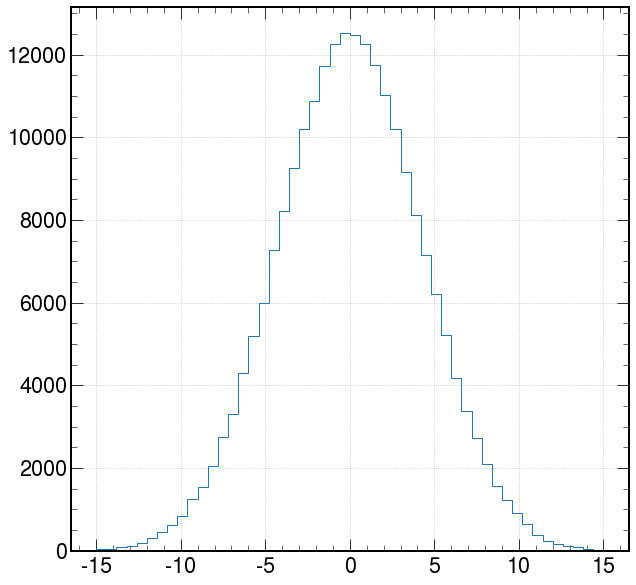

In [453]:
pm.mc.pv_MC.hist(histtype="step", bins=50, range=(-15, 15))
print(np.median(pm.mc.pv_MC))

<AxesSubplot:>

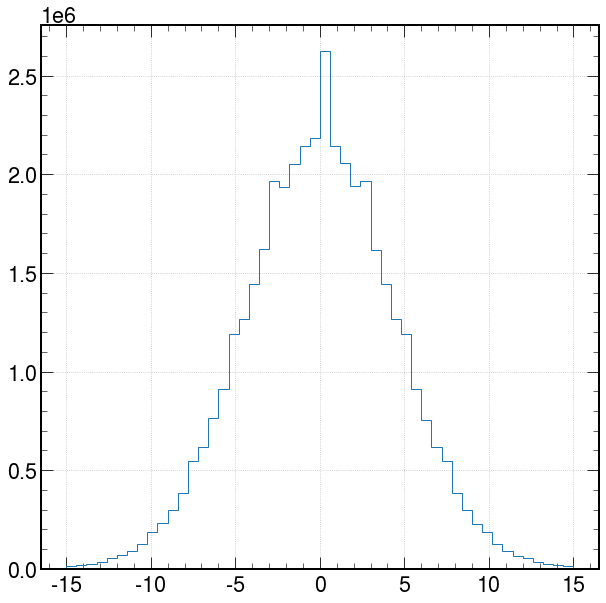

In [454]:
pm.trk.trk_z0.hist(histtype="step", bins=50, range=(-15, 15))

In [456]:
trk_count = pm.trk.groupby(level=0)["trk_z0"].count().values

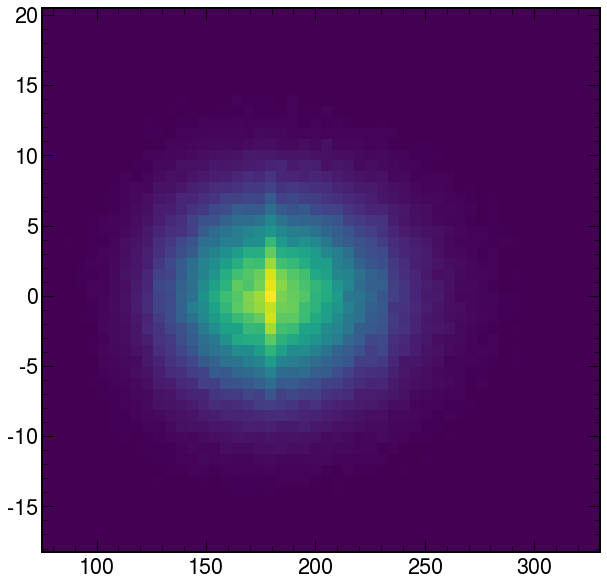

In [459]:
_ = plt.hist2d(trk_count, pm.mc["pv_MC"].values, bins=50)

In [460]:
pm.trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry  subentry                                                             
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
       4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                   ...       ...       ...     ...       ...       ...   
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2   
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2   
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2   
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2   
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2   

                 is_pv  z0_reco_fh  distance_from_pv_fh  trk_pv_assoc_fh  \
entry  subentry                                                            
0      0             0    4.863511             5.861216              0.0   
       1             0    4.863511             1.642466              0.0   
       2             1    4.863511             0.060434              1.0   
       3             0    4.863511             5.451059              0.0   
       4             1    4.863511             0.001841              1.0   
...                ...         ...                  ...              ...   
222975 211           0    1.347886             0.353403              0.0   
       212           0    1.347886             7.380972              0.0   
       213           0    1.347886             1.701060              1.0   
       214           0    1.347886             6.212778              0.0   
       215           0    1.347886             0.470591              1.0   

                 z0_reco_db  trk_pv_assoc_db  distance_from_pv_db  \
entry  subentry                                                     
0      0           4.980469                0             5.893772   
       1           4.980469                0             1.675022   
       2           4.980469                1             0.092991   
       3           4.980469                0             5.483616   
       4           4.980469                1             0.034397   
...                     ...              ...                  ...   
222975 211         1.113281                1             0.034397   
       212         1.113281                0             7.699978   
       213         1.113281                0             1.382054   
       214         1.113281                0             5.893772   
       215         1.113281                1             0.151585   

                 trk_pv_assoc_db2  trk_pv_assoc_fh2  event_number  \
entry  subentry                                                     
0      0                      0.0               0.0             0   
       1                      0.0               0.0             0   
       2                      1.0               1.0             0   
       3                      0.0               0.0             0   
       4                      1.0               1.0             0   
...                           ...               ...           ...   
222975 211                    0.0               0.0        222975   
       212                    0.0               0.0        222975   
       213                    1.0               1.0        222975   
       214                    0.0               0.0        222975   
       215                    1.0               1.0        222975   

                 z0_reco_fh_cor  z0_reco_db_cor     pv_MC  
entry  subentry                                            
0      0               4.982309        5.014866  5.055163  
       1               4.982309        5.014866  5.0

In [466]:
bw = 1
z0_bins = np.arange(-15, 15 + bw, bw)
x = 0.5 * (z0_bins[1:] + z0_bins[:-1])
n_tracks = []

for z0_bin in z0_bins[:-1]:
    print(z0_bin)
    mask = (pm.trk.pv_MC > z0_bin) & (pm.trk.pv_MC < z0_bin + bw)

    n_track = pm.trk[mask].groupby(level=0)["trk_z0"].count().mean()

    n_tracks.append(n_track)

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [465]:
n_tracks

[]

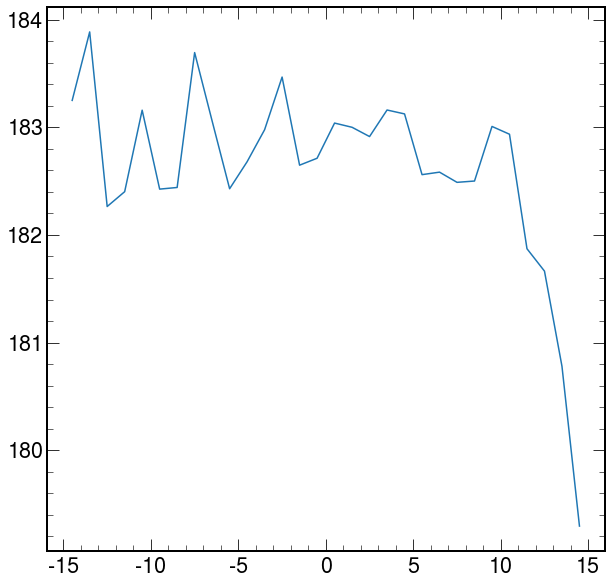

In [467]:
plt.plot(x, n_tracks)